# Kernel Tuner Backends Test

This notebook is intended to examine performance differences in the Kernel Tuner backends.

In [1]:
from pathlib import Path
import json
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# arguments
kernel = "gemm_opencl_cuda"
expected_keys = ['time', 'GFLOP/s', 'compile_time', 'benchmark_time', 'framework_time', 'REPEAT']
observer_keys = ['mem_freq', 'core_freq', 'temperature', 'num_regs']
backend_displaynames = {
    'CUDA': 'PyCUDA',
    'CUPY': 'CuPy',
    'NVCUDA': 'CUDA-Python',
}
backends = sorted(list(backend_displaynames.values()))
cuda_versions = ['11.2', '12.3']
plot_height = 6
plot_aspect = 2.0

In [10]:
def get_dataframe(observers=False, old_data=False) -> pd.DataFrame:

    # get the path to the cachefiles directory
    if old_data:
        folder_clock = "variable_clock_size-4096"
        folder_observers = "observers" if observers else "no_observers"
        cachefiles_path = Path("kernels/outputdata").resolve() / folder_clock / folder_observers
    else:
        cachefiles_path = Path("kernels/outputdata").resolve() / kernel
    assert cachefiles_path.exists()

    # get all relevant cachefiles
    cachefiles : list[Path] = []
    for file in cachefiles_path.iterdir():
        if file.is_file() and file.name.startswith(kernel) and "_noisetest" in file.name and "_cache" in file.name and file.suffix == '.json':
            cachefiles.append(file)

    # create a list of dictionaries of the data
    cache_dicts = list()
    for filepath in cachefiles:
        cachefile = json.load(filepath.open())
        device_name = cachefile['device_name']
        backend = backend_displaynames[re.search(r"_backend-([a-zA-Z]+)_", filepath.name).group(1).strip()]
        CUDA_version = re.search(r"_CUDA-(.*)_", filepath.name).group(1).strip()
        CUDA_backend= f"c:{CUDA_version} | b:{backend}"
        backend_CUDA = f"b:{backend} | c:{CUDA_version}"
        # for each of the configurations, create a dictionary with the expected items
        for value in cachefile['cache'].values():
            assert isinstance(value, dict)
            cache = {}
            cache['device_name'] = device_name
            cache['backend'] = backend
            cache['backend | CUDA version'] = backend_CUDA
            cache['CUDA version | backend'] = CUDA_backend
            cache['CUDA version'] = CUDA_version
            for key in expected_keys:
                cache[key] = value[key]
            if observers:
                for key in observer_keys:
                    if key in value:
                        cache[key] = value[key]
            cache_dicts.append(cache)

    # create a dataframe out of the dictionaries
    return pd.DataFrame(cache_dicts)

In [11]:
df = get_dataframe(observers=False)

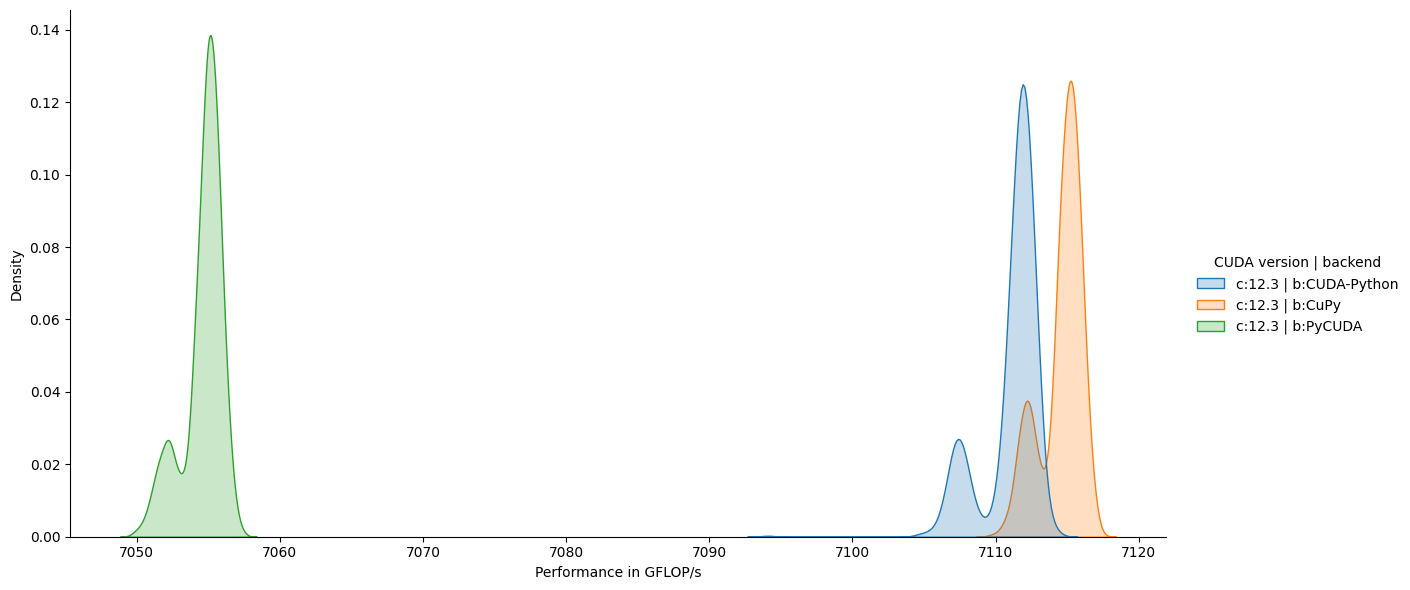

In [5]:
g = sns.displot(data=df.sort_values(['CUDA version', 'backend']), x='GFLOP/s', hue='CUDA version | backend', kind='kde', fill=True, height=plot_height, aspect=plot_aspect)
g = g.set_xlabels("Performance in GFLOP/s")

The figure above shows a histogram for each combination of CUDA version and backend. The difference in performance between the CUDA 11.2 and 12.3 is quite visible. Whereas with CuPy CUDA 12.3 slightly outperforms 11.2, for PyCUDA the difference is very tangible. 

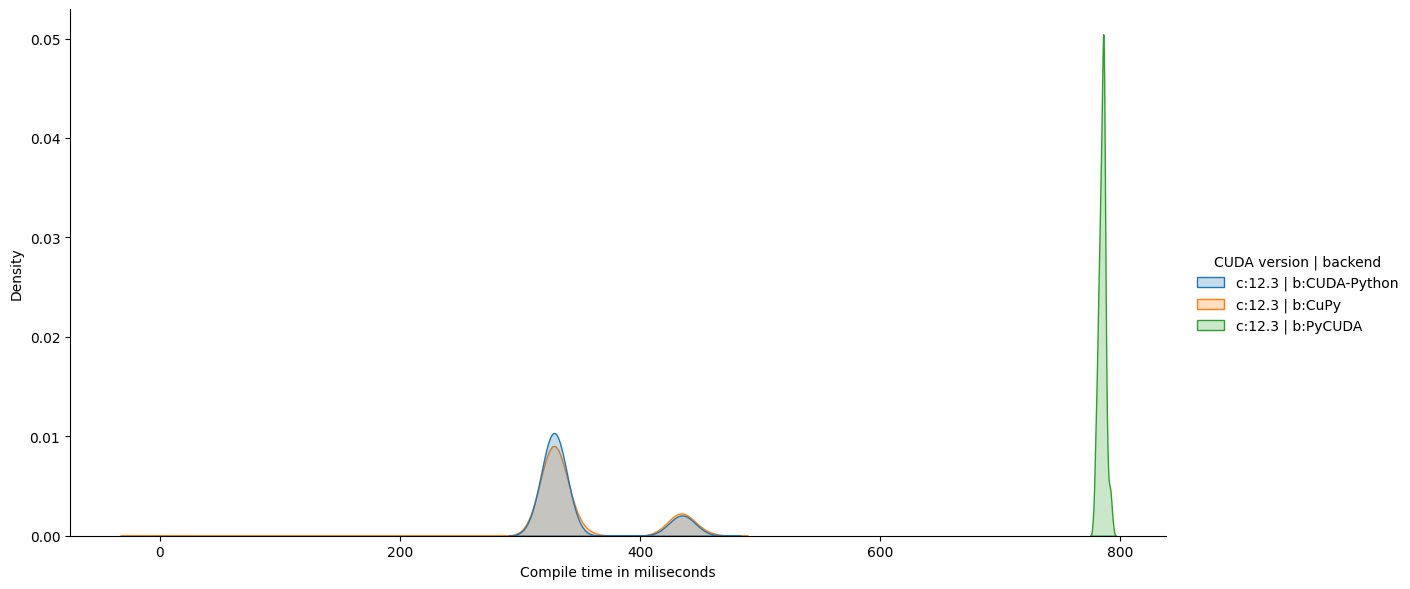

In [6]:
g = sns.displot(data=df.sort_values(['CUDA version', 'backend']), x='compile_time', hue='CUDA version | backend', kind='kde', fill=True, height=plot_height, aspect=plot_aspect)
g = g.set_xlabels("Compile time in miliseconds")

However, PyCUDA's performance gain comes at a cost: it also has the highest compile time of all the backends, regardless of CUDA version. It is also notable that CUDA-Python has a much more stable compilation time than the other backends. The CuPy compile time on CUDA 12.3 is very similar to that of CUDA-Python as they both use NVRTC, whereas PyCUDA uses NVCC. 

Text(0, 0.98, 'backend | CUDA version')

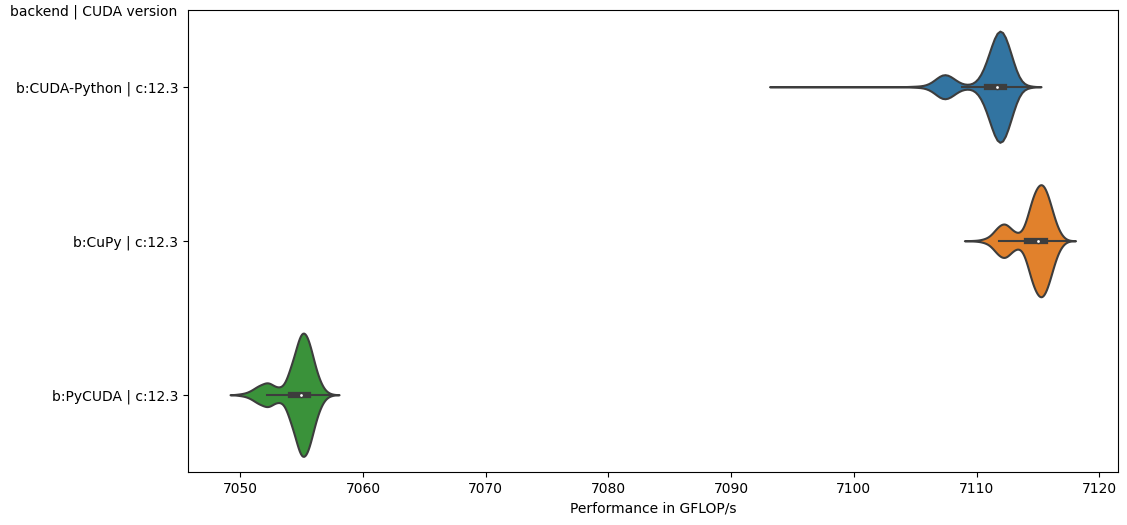

In [7]:
fig = plt.gcf()
fig.set_size_inches(plot_aspect*plot_height, plot_height)
g = sns.violinplot(data=df.sort_values(['CUDA version', 'backend']), x='GFLOP/s', y='backend | CUDA version')
g.set_xlabel("Performance in GFLOP/s")
g.set_ylabel('backend | CUDA version', rotation=0, y=.98, horizontalalignment='left')

## Investigating with Observers

In [12]:
df = get_dataframe(observers=True)

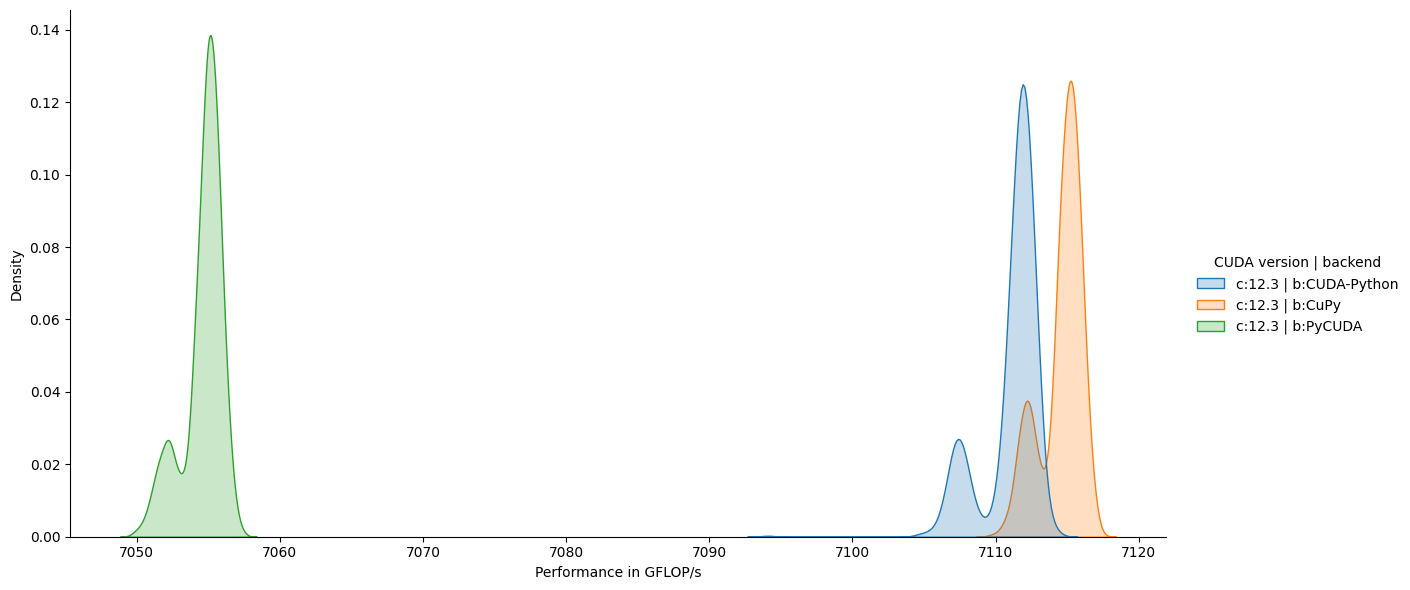

In [13]:
g = sns.displot(data=df.sort_values(['CUDA version', 'backend']), x='GFLOP/s', hue='CUDA version | backend', kind='kde', fill=True, height=plot_height, aspect=plot_aspect)
g = g.set_xlabels("Performance in GFLOP/s")

Sanity check: do we still see the same distributions with observers as we did without?

In [14]:
plt.figure(figsize=(plot_aspect*plot_height, plot_height))
g = sns.barplot(data=df.sort_values(['CUDA version', 'backend']), x='CUDA version | backend', y="num_regs", estimator=np.mean, errorbar='sd', capsize=.2)
g.bar_label(g.containers[0])
g.set_ylabel("Average number of registers used")

ValueError: Could not interpret input 'num_regs'

<Figure size 1200x600 with 0 Axes>

Looking at the average number of registers, there is a small difference with PyCUDA using one additional register. 

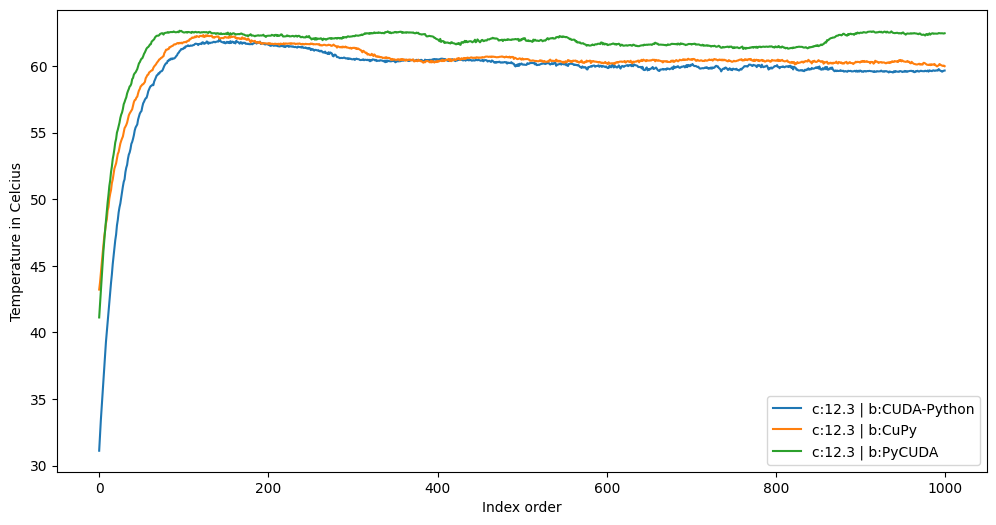

In [15]:
plt.figure(figsize=(plot_aspect*plot_height, plot_height))
for backend in backends:
    for cuda_version in cuda_versions:
        f_df = df.loc[(df['backend'] == backend) & (df['CUDA version'] == cuda_version)]
        if f_df.size > 0:
            sns.lineplot(data=f_df.sort_values(['temperature']), y='temperature', x='REPEAT', label=f_df['CUDA version | backend'].iloc[0])
plt.ylabel("Temperature in Celcius")
plt.xlabel("Index order")
plt.legend()